In [2]:
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.signal import correlate
import sys

from tqdm import tqdm

In [3]:
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

In [4]:
def imshow_box(image, image_reconstructed,  box_pos, box_width, box_height):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_reconstructed = cv2.cvtColor(image_reconstructed, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
      image_reconstructed = cv2.cvtColor(image_reconstructed, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Draw the image
    plt.subplot(1,2,2)
    plt.imshow(image_reconstructed)
    # draw a red box
    rect = patches.Rectangle((box_pos[0], box_pos[1]), box_width, box_height, linewidth=0.75, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title('Reconstructed')
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

### Load the Image and convert it to GRAY
First set up the specifications for the image we're working on and the location of the (rectangular) mask
Try other images too!

In [5]:
image_name = "brick.png"

maskxmin = 200
maskxmax = 250
maskymin = 100
maskymax = 150

context_height = 5
context_width = 5

In [6]:
rootpath='./'
image = cv2.cvtColor(cv2.imread(os.path.join(rootpath, image_name)), cv2.COLOR_BGR2GRAY)

Check the type - note the order of the dimensions shape has (height = y, width = x)

In [7]:
type(image), image.shape, image.dtype

(numpy.ndarray, (312, 626), dtype('uint8'))

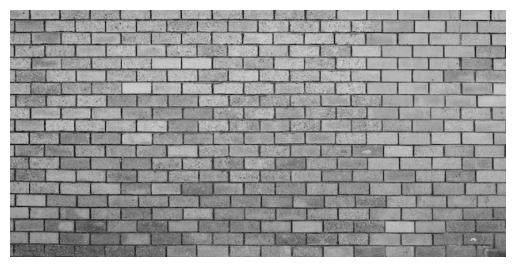

In [7]:
imshow(image)

### Make a mask and blot out part of the image

In [8]:
def makemask(im, minx, maxx, miny, maxy):
    result = np.zeros_like(im)
    for x in range(minx,maxx):
        for y in range(miny,maxy):
            result[y,x]=1
    return result

In [9]:
mask = makemask(image, maskxmin, maskxmax, maskymin, maskymax)

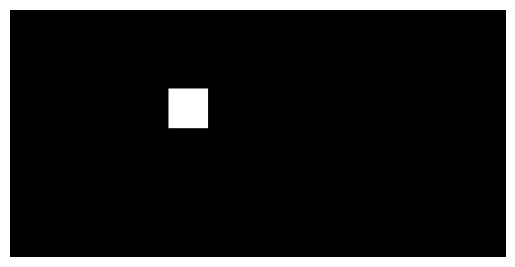

In [10]:
imshow(mask*255) # multiply by 255 so we can see the mask value as white

Black out the mask on the bird image
NB: 1-mask is zero inside the square and 1 everywhere else
when we multiply it by the bird image we get zeros in the square and retain the other pixels

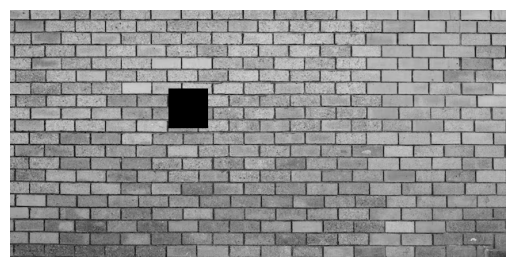

In [11]:
masked_image = image * (1-mask)

imshow(masked_image)

### Define the region we're going to use to find close matches

Make a dictionary of offset locations
We're going to reconstruct one pixel at a time based on local context.
We'll start by using a 5x5 context to reconstruct the bottom right pixel so that we can always reconstruct the left most pixel in the first masked row.

In [12]:
def make_context_locations(height,width):
    array_size = (height*width-1,2)
    offsets = np.empty(shape=(0,2),dtype=int)
    for x in range(1-width,1):
        for y in range (1-height,1):
            if y!=0 or x!=0:
                offsets = np.concatenate((offsets, np.array([[y,x]])),axis=0)
    return offsets

In [13]:
offsets = make_context_locations(context_height, context_width)
#print(offsets)

### Make an array of source patterns in the image
We're going to make two arrays: one is the set of valid source patterns that draw pixel colours from the offsets. This is the set of "patterns"
The other is the set of pixel values corresponding to those patterns. This is the set of "values"
For a square shaped context we need to make sure that the whole square is valid

In [14]:
def get_pattern(image, position, offsets, mask, normalize=False):
    num_offsets = offsets.shape[0]
    pattern = np.empty(shape=(1,num_offsets),dtype=int)
    value = np.empty(shape=(1,1),dtype=int)
    if mask is not None:
        if mask[position[0],position[1]]:
            return (None,None)
    value = image[position[0],position[1]]
    for i in range(num_offsets):
        offset = offsets[i]
        pos = position+offset
        if pos[0]<0 or pos[0] >= image.shape[0] or pos[1] < 0 or pos[1] >= image.shape[1]:
            return (None,None)
        if mask is not None:
            if mask[pos[0],pos[1]]:
                return (None,None)
        pattern [0,i] = image[pos[0],pos[1]]

    if normalize:
        # normalize the patters so that they all have l2-norm of 1
        pattern = pattern / np.linalg.norm(pattern)     
        
    return (pattern,value)

This next cell takes a little while to run

In [15]:
def get_all_patterns(image, offsets, mask, normalize=False):
    num_offsets = offsets.shape[0]
    num_pixels = image.shape[0] * image.shape[1]

    # make the arrays larger than we need to start with - we can trim them later
    patterns = np.empty(shape=(num_pixels,num_offsets),dtype=int)
    values = np.empty(shape=(num_pixels,1),dtype=int)

    # counter keeps track of how much of the arrays we've filled in
    counter = 0
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            position=np.array([y,x])
            (pattern,value) = get_pattern(image, position, offsets, mask, normalize)
            if pattern is not None:
                patterns[counter] = pattern
                values[counter] = value
                counter = counter + 1
                
    # now trim the arrays to the right length
    patterns = patterns[0:counter,:]
    values = values[0:counter,:]

    return (patterns, values)

In [16]:
patterns, values = get_all_patterns(image, offsets, mask, normalize=False)
print (patterns.shape)
print (values.shape)

(188660, 24)
(188660, 1)


### Reconstruct the image
Now we have the set of patterns and values - we can use these to fill in the blanks from the mask
We do this by finding the pattern that has the least sum of squares difference to the pattern for the pixel we want to fill in. We then fill in the pixel with the value from that location in the values array. Pixels are filled in raster scan order (from the top down filling each row from left to right).

This cell takes even longer to run - if you're not sure it's making progress, trying printing out each y value

In [17]:
# computes sum of squared difference between patterns
def diff_ssd(patterns, pattern):
    differences = patterns-pattern
    diffsq = differences * differences
    diffsumsq = diffsq.sum(axis=1)
    return diffsumsq

# computes sum of absolute difference between patterns
def diff_sad(patterns, pattern):
    differences = patterns-pattern
    diffabs = np.abs(differences)
    diffsad = diffabs.sum(axis=1)
    return diffsad


# computes the cross correlation between normalized patterns
def diff_normalized_cross_corr(patterns, pattern):
    cross_corr = correlate(patterns, pattern, mode='valid').reshape(-1)
    return cross_corr


def infill_image(masked_image, mask, patterns, values, offsets, similarity_metric='ssd'):
    with tqdm(total=masked_image.shape[0], ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
        for y in range(masked_image.shape[0]):
            for x in range(masked_image.shape[1]):
                if(mask[y,x]):
                    position = np.array([y,x])
                    (pattern, value) = get_pattern(masked_image,position,offsets,None)

                    if similarity_metric == 'ssd':
                        # pattern similarity measured by sum of squared differences 
                        diffsumsq = diff_ssd(patterns, pattern)  #diffsq.sum(axis=1)
                        best_pattern = np.argmin(diffsumsq)

                    elif similarity_metric == 'sad':                        
                        # pattern similarity measured by sum of absolute differences 
                        diffsad = diff_sad(patterns, pattern)  #diffsq.sum(axis=1)
                        best_pattern = np.argmin(diffsad)

                    elif similarity_metric == 'cc':
                        # pattern similarity measured by normalized cross-correlation
                        cross_corr = diff_normalized_cross_corr(patterns, pattern)
                        best_pattern = np.argmax(cross_corr)

                    else:
                        raise RuntimeError("Unsupported option. Aborting.")
                    

                    masked_image[position[0],position[1]] = values[best_pattern]
            pbar.update(1)

    return masked_image            

In [18]:
masked_image = infill_image(masked_image, mask, patterns, values, offsets, similarity_metric='ssd')

  0%|                                                                    | 0/312

100%|██████████████████████████████████████████████████████████████████| 312/312


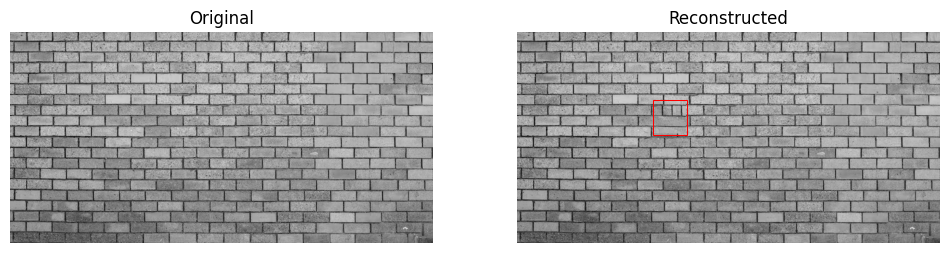

In [19]:
box_pos = (maskxmin, maskymin)
box_width = maskxmax-maskxmin+1
box_height = maskymax-maskymin+1
imshow_box(image, masked_image, box_pos, box_width, box_height)

### Evaluate the reconstruction

In [20]:
#first convert the images to numpy arrays with dtype = int so that we don't have problems with negatives and uint8
def rms_error(image, masked_image, mask):
    npim = np.array(image, dtype=int)
    npmasked = np.array(masked_image, dtype=int)

    #take the difference, square it and sum
    diff_image = npim - npmasked
    diffsqimage = diff_image*diff_image
    sumsqerror = diffsqimage.sum()

    #divide by the number of pixels in the mask
    avgsqerror = sumsqerror / mask.sum()
    rmserror = np.sqrt(avgsqerror)

    #print(rmserror)
    return rmserror


In [21]:
rms_error(image, masked_image, mask)

35.719473680332975

### Comments
This reconstruction looked okay-ish but you can do better!

Some ideas:
- Try different context sizes and shapes (change the definition of make_context_locations)
- Context pixels don't have to be adjacent
- Maybe top down isn't the right order to fill things in?
- Maybe sum of squared differences isn't the right way to find the best pattern?
- Maybe you should randomly sample from the values weighted by pattern difference?

### 1. Reconstruction error analysis

Create 5 different mask locations. Using the default settings, compute rms error for reconstruction at each mask location along along with the average rms error across these 5 mask locations. Do this for both test images. 

(312, 626)


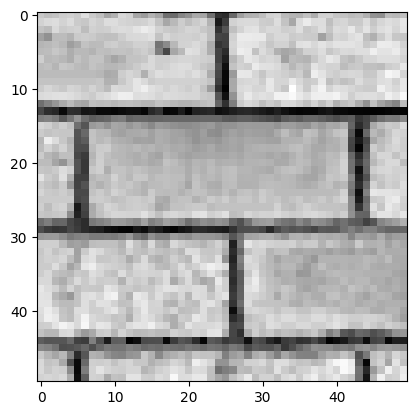

In [22]:
brick_image = cv2.cvtColor(cv2.imread('./brick.png'), cv2.COLOR_BGR2GRAY)
print(brick_image.shape)
plt.imshow(brick_image[0:50,0:50], cmap='gray')

Close up view to get an idea about the size of each brick

(351, 626)


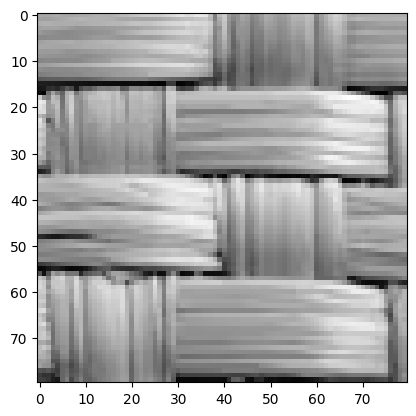

In [23]:
basket_image = cv2.cvtColor(cv2.imread('./basket.png'), cv2.COLOR_BGR2GRAY)
print(basket_image.shape)
plt.imshow(basket_image[0:80,0:80], cmap='gray')

Close-up view to get scale of the basket weaves

In [24]:
# pick 5 masks for each image
mask1 = {'xmin':200, 'ymin':100, 'size':50} #{'xmin':65, 'ymin':60, 'size':50}
mask2 = {'xmin':97, 'ymin':230, 'size':50}
mask3 = {'xmin':315, 'ymin':200, 'size':50}
mask4 = {'xmin':400, 'ymin':80, 'size':50}
mask5 = {'xmin':560, 'ymin':255, 'size':50}
mask_size = 50
masks_pos = [mask1, mask2, mask3, mask4, mask5]

brick_mask1 = makemask(brick_image, mask1['xmin'], mask1['xmin']+mask_size, mask1['ymin'], mask1['ymin']+mask_size)
brick_mask2 = makemask(brick_image ,mask2['xmin'], mask2['xmin']+mask_size, mask2['ymin'], mask2['ymin']+mask_size)
brick_mask3 = makemask(brick_image, mask3['xmin'], mask3['xmin']+mask_size, mask3['ymin'], mask3['ymin']+mask_size)
brick_mask4 = makemask(brick_image, mask4['xmin'], mask4['xmin']+mask_size, mask4['ymin'], mask4['ymin']+mask_size)
brick_mask5 = makemask(brick_image, mask5['xmin'], mask5['xmin']+mask_size, mask5['ymin'], mask5['ymin']+mask_size)
brick_masks = [brick_mask1, brick_mask2, brick_mask3, brick_mask4, brick_mask5]

basket_mask1 = makemask(basket_image, mask1['xmin'], mask1['xmin']+mask_size, mask1['ymin'], mask1['ymin']+mask_size)
basket_mask2 = makemask(basket_image ,mask2['xmin'], mask2['xmin']+mask_size, mask2['ymin'], mask2['ymin']+mask_size)
basket_mask3 = makemask(basket_image, mask3['xmin'], mask3['xmin']+mask_size, mask3['ymin'], mask3['ymin']+mask_size)
basket_mask4 = makemask(basket_image, mask4['xmin'], mask4['xmin']+mask_size, mask4['ymin'], mask4['ymin']+mask_size)
basket_mask5 = makemask(basket_image, mask5['xmin'], mask5['xmin']+mask_size, mask5['ymin'], mask5['ymin']+mask_size)
basket_masks = [basket_mask1, basket_mask2, basket_mask3, basket_mask4, basket_mask5]


In [25]:
# apply masks to the images
brick_image_mask1 = brick_image*(1-brick_mask1)
#imshow(brick_image_mask1) 
brick_image_mask2 = brick_image*(1-brick_mask2)
#imshow(brick_image_mask2) 
brick_image_mask3 = brick_image*(1-brick_mask3)
#imshow(brick_image_mask3) 
brick_image_mask4 = brick_image*(1-brick_mask4)
#imshow(brick_image_mask4) 
brick_image_mask5 = brick_image*(1-brick_mask5)
#imshow(brick_image_mask5) 

In [26]:
# reconstruct inside each mask and compute average rms error of reconstruction
def reconstruction_rms_error(image, masks, masks_pos, generate_context_offsets, context_width=5, context_height=5):

    avg_rms_error = 0

    for mask, mask_pos in zip(masks, masks_pos):

        print(f"Mask 1, xmin: {mask_pos['xmin']},  ymin: {mask_pos['ymin']}, mask size: {mask_pos['size']}")

        # compute offsets
        offsets = generate_context_offsets(context_height, context_width)

        # masked image
        masked_image = image * (1 - mask)

        # get all context patterns
        patterns, values = get_all_patterns(image, offsets, mask)

        # infill/reconstruct from masked image
        masked_image = infill_image(masked_image, mask, patterns, values, offsets)

        # compute rms error
        error = rms_error(image, masked_image, mask)
        avg_rms_error += error 
        print(f"reconstruction rms error: {error}")

        # show the images
        box_pos = (mask_pos['xmin'], mask_pos['ymin'])
        box_width = mask_pos['size']
        box_height = mask_pos['size']
        imshow_box(image, masked_image, box_pos, box_width, box_height)

    avg_rms_error = avg_rms_error/len(masks)
    print(f"Average rms error = {avg_rms_error}")
    return avg_rms_error    

Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 35.719473680332975


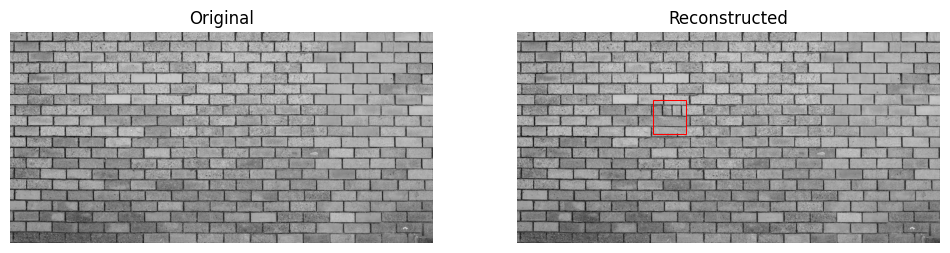

Mask 1, xmin: 97,  ymin: 230, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 33.87975206520851


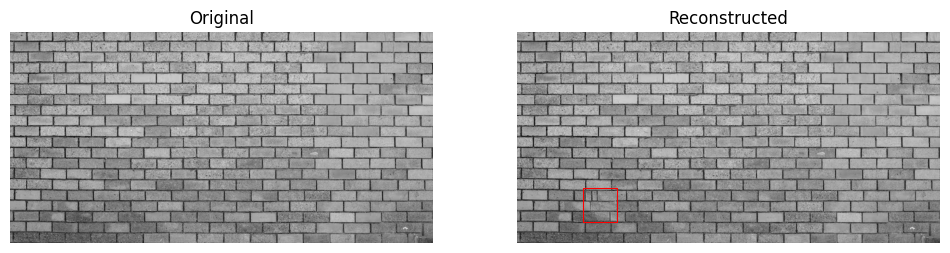

Mask 1, xmin: 315,  ymin: 200, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 32.21425771300652


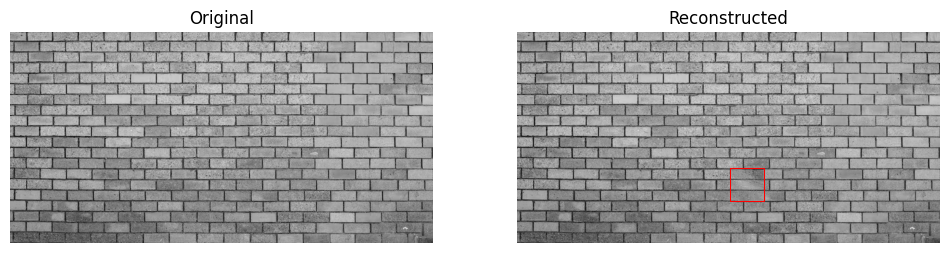

Mask 1, xmin: 400,  ymin: 80, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 33.12368940803545


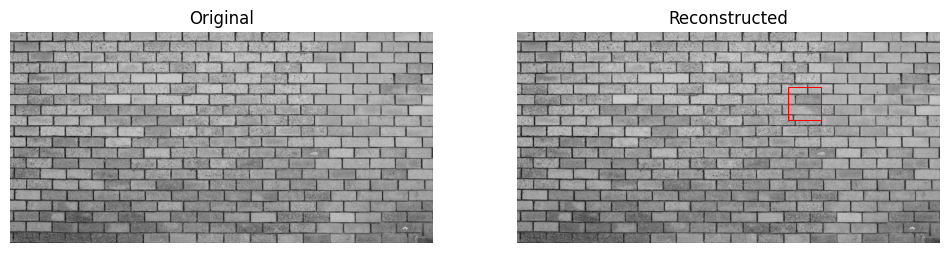

Mask 1, xmin: 560,  ymin: 255, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 32.80299986281743


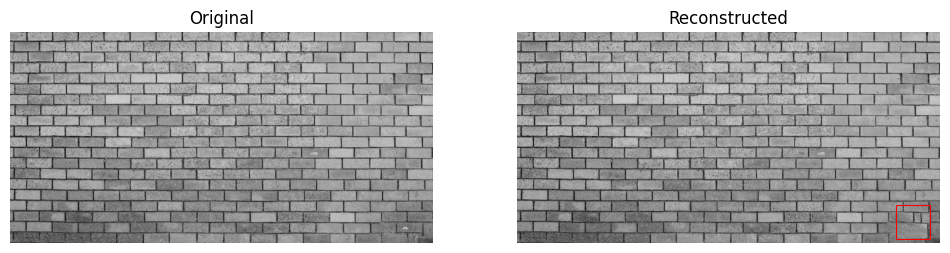

Average rms error = 33.54803454588017


In [29]:
brick_err = reconstruction_rms_error(brick_image, brick_masks, masks_pos, make_context_locations, context_height=5, context_width=5)

(x,y) pixel coordinates of top-left corner of mask (height and width of 50 pixels) , and rms error for brick image:

| Mask Location | rms error |
|---------------|-----------|
|   (200,100)   |   35.72   |
|   (97, 230)   |   33.89   |
|   (315,200)   |   32.21   |
|   (400, 80)   |   33.12   |
|   (560,255)   |   32.80   |

Average rms error: 33.55

Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351


reconstruction rms error: 46.594094046348836


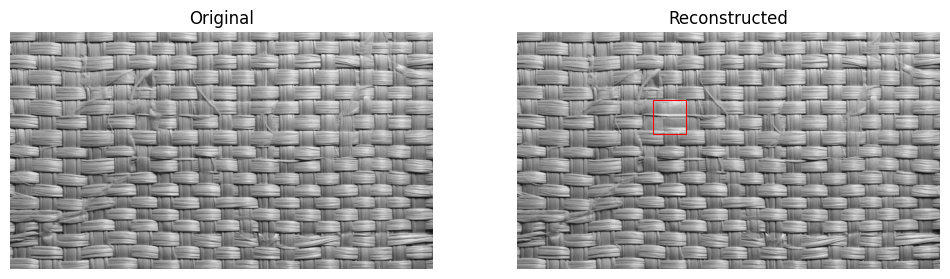

Mask 1, xmin: 97,  ymin: 230, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351


reconstruction rms error: 49.356345083484456


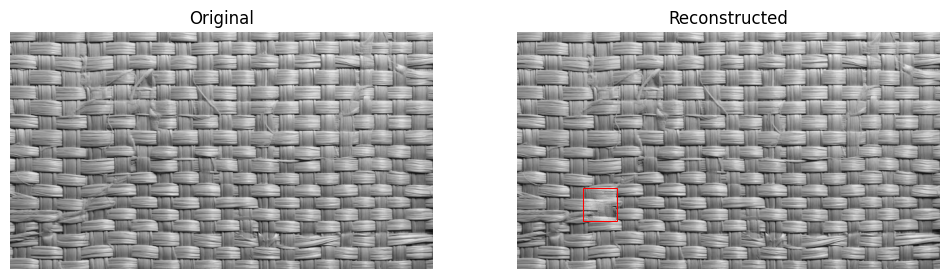

Mask 1, xmin: 315,  ymin: 200, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351


reconstruction rms error: 51.29750091378721


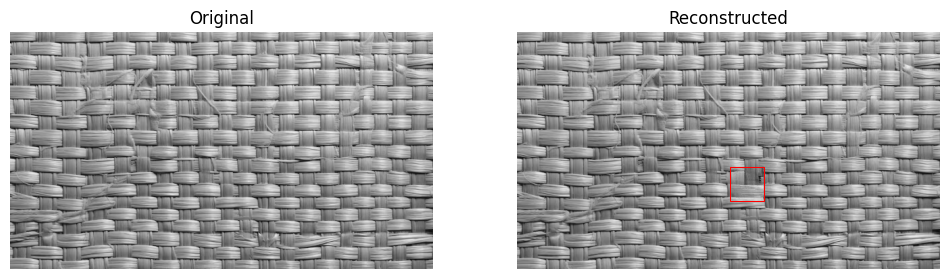

Mask 1, xmin: 400,  ymin: 80, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351

reconstruction rms error: 35.750625169358926


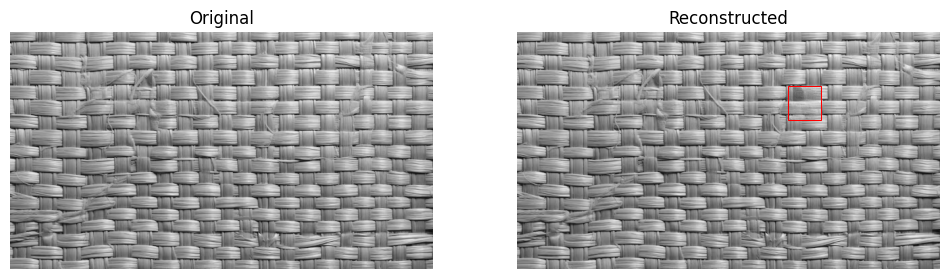

Mask 1, xmin: 560,  ymin: 255, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351

reconstruction rms error: 53.56865874744299


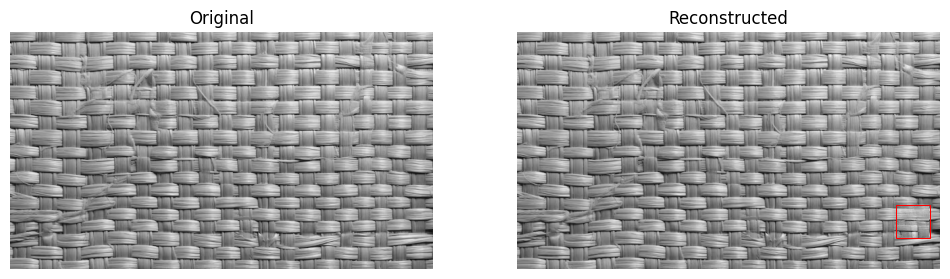

Average rms error = 47.31344479208448


In [30]:
basket_err = reconstruction_rms_error(basket_image, basket_masks, masks_pos, make_context_locations, context_height=5, context_width=5)

(x,y) pixel coordinates of top-left corner of mask (height and width of 50 pixels) , and rms error for basket image:

| Mask Location | rms error |
|---------------|-----------|
|   (200,100)   |   46.59   |
|   (97, 230)   |   49.36   |
|   (315,200)   |   51.30   |
|   (400, 80)   |   35.75   |
|   (560,255)   |   53.57   |

Average rms error: 47.31

### 2. Context size and shape

Try different sizes and shapes for the context windows, how does it affect the reconstruction quality? 

Context window :(2, 2)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 62.7687788633808


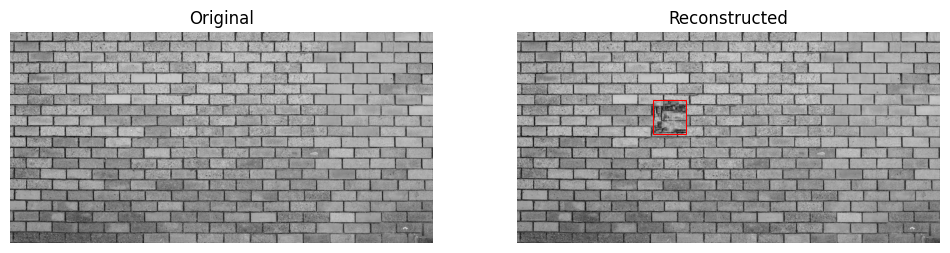

Average rms error = 62.7687788633808
Context window :(5, 5)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 35.719473680332975


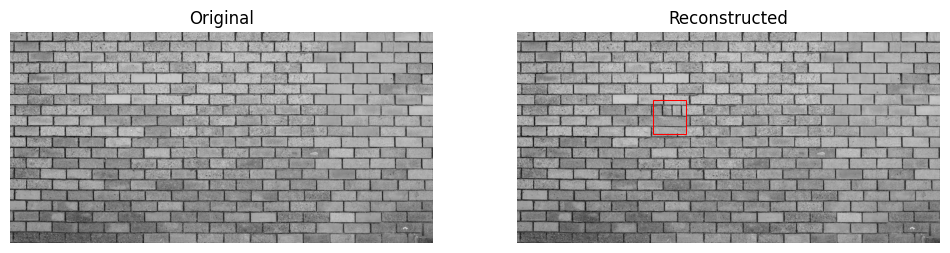

Average rms error = 35.719473680332975
Context window :(25, 12)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 27.45613228406361


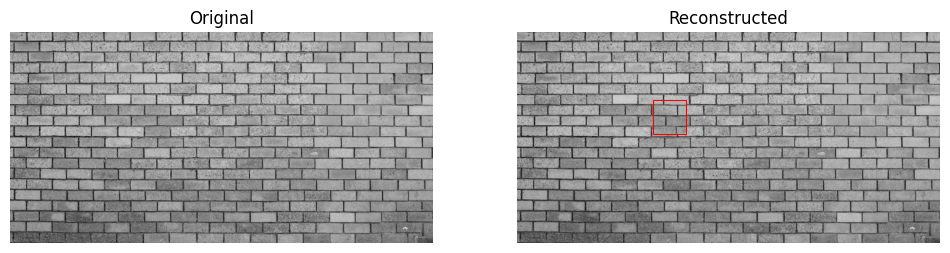

Average rms error = 27.45613228406361
Context window :(42, 22)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 312/312


reconstruction rms error: 24.49194969780887


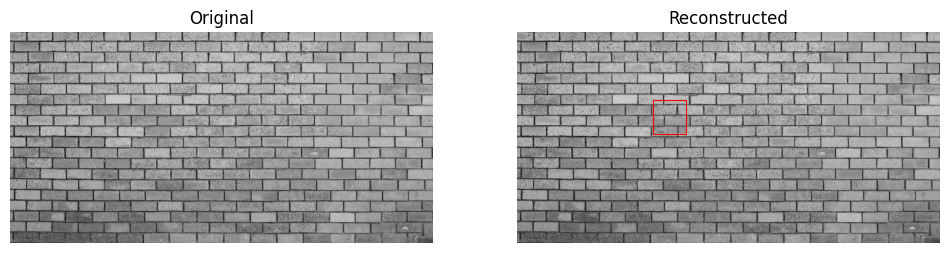

Average rms error = 24.49194969780887


In [39]:
context_windows = [(2,2), (5,5), (25, 12),(42,22)]

for window in context_windows:
    print(f"Context window :{window}")
    brick_err = reconstruction_rms_error(brick_image, [brick_masks[0]], [masks_pos[0]], make_context_locations, context_width=window[0], context_height=window[1])

Context window :(2, 2)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351

reconstruction rms error: 50.06724278407989


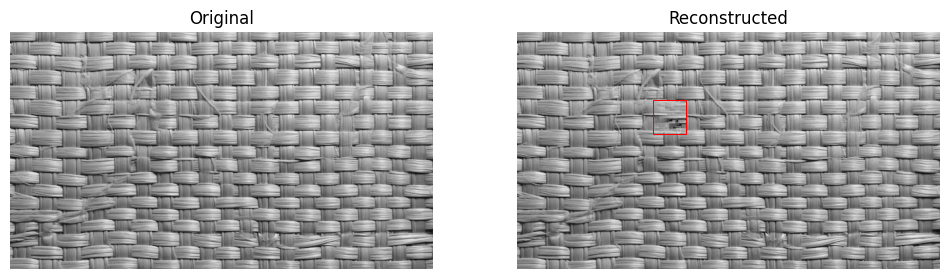

Average rms error = 50.06724278407989
Context window :(5, 5)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351

reconstruction rms error: 46.594094046348836


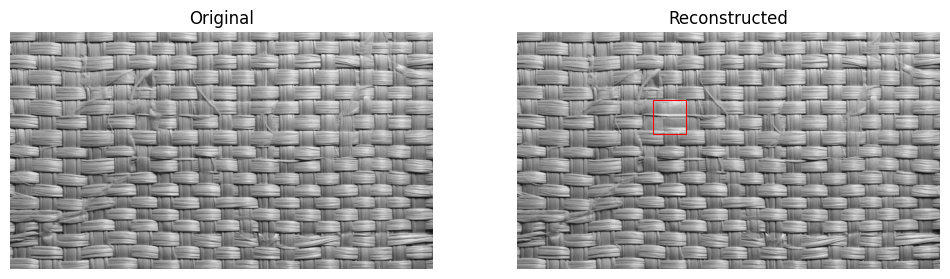

Average rms error = 46.594094046348836
Context window :(25, 12)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351

reconstruction rms error: 44.740621363588595


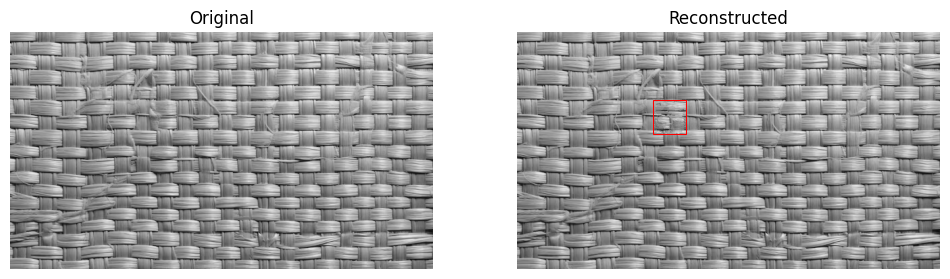

Average rms error = 44.740621363588595
Context window :(50, 20)
Mask 1, xmin: 200,  ymin: 100, mask size: 50


100%|██████████████████████████████████████████████████████████████████| 351/351


reconstruction rms error: 43.74790966434853


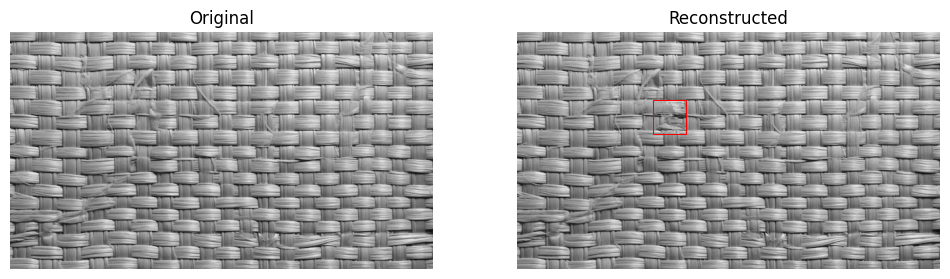

Average rms error = 43.74790966434853


In [38]:
context_windows = [(2,2), (5,5), (25, 12), (50,20)]

for window in context_windows:
    print(f"Context window :{window}")
    basket_err = reconstruction_rms_error(basket_image, [basket_masks[0]], [masks_pos[0]], make_context_locations, context_width=window[0], context_height=window[1])

If our image contains a periodic texture, such as in our brick image, then if the context window is too small (2x2), the window is unable to capture the full periodic structure and the local details in the texture, leading to poor reconstruction quality. As we increase the size of the context window, we start to capture some of the regularity of the texture in our reconstruction, however we see some artifcats, for instance we obtain bricks of incorrect length. When we make the context window large enough so that it captures the full periodic structure (which for the case of the bricks image would be roughly the size of a brick), we obtain very good reconstruction and no visible artifacts. Evidently, we also note that the rms error sharply decreases as the context window becomes larger which confirms that the reconstruction quality has improved.  

Our basket image also contains a strong periodic structure, however it also contains a small stochastic component, due to the imperfections in the weaves. For this reason, even if the context window is not large enough to capture the full periodic structure, we find that the artifacts generated by the reconstruction are visually similar to the stochastic imperfections in the original texture of the basket weaves and so the quality of the reconstruction is fairly good and further increasing the window size does not cause any significant change in quality. We can see that the rms error does not dcrease appreciably as we make the context window larger, confirming our observations from visually inspecting the recontructed images. 

### 3) Reconstruction design

Modify the inpainting algorithm to improve it's performance. Some ideas:

- Could try rectangular shaped context window, roughly the size of each brick/basket weave so that it can capture the full periodic structure of the pattern
- Could try filling blocks of pixels at a time rather than pixel by pixel 
- Instead of using the most similar patch, can use a weighted average of say the top 5 most similar patches
- Could try randomly sampling a patch, weighted by the similarity score
- Instead of square patches, could try other patahc shapes, maybe circular or even jagged/irregular shapes
- Could adaptively change patch size/shape
- Different patch similarity metrics other than sum of least squares, e.g. normalized cross-correlation
- Instead of directly using pixelwise similarity measure, use a pre-trained CNN model to convert patches into some hidden feature space and measure similarity in that space, this could potentially be useful for capturing more meaningful semantic similarity between patches 

Idea 1: Inpainting by blocks instead of per pixel. In this case, we modify the context window such that the target pixel is group of pixels in the bottom right of the window.

In [ ]:
def make_context_locations_bottomright(height, width, blocksize=1):
    array_size = (height*width-1,2)
    offsets = np.empty(shape=(0,2),dtype=int)
    for x in range(1-width,1-(blocksize+1)):
        for y in range (1-height,1-(blocksize+1)):
            if y!=0 or x!=0:
                offsets = np.concatenate((offsets, np.array([[y,x]])),axis=0)
    return offsets





Idea 2: Onion peel inpainting. In this case, we choose a very large context window that contains the entire masked region and we fill the enitre outermost layer of the masked region ata a time.